Find the markdown blocks that say interaction required! The notebook should take care of the rest!

# Import libs

In [1]:
import sys
import os
sys.path.append('..')
from eflow.foundation import DataPipeline
from eflow.foundation import DataFrameTypes
from eflow.data_analysis import FeatureAnalysis
from eflow.data_analysis import NullAnalysis
from eflow.model_analysis import ClassificationAnalysis
from eflow.utils.pandas_utils import data_types_table, value_counts_table, suggest_removal_features 
from eflow.utils.modeling_utils import optimize_model_grid
from eflow.utils.eflow_utils import get_type_holder_from_pipeline
from eflow.utils.math_utils import get_unbalanced_threshold
from eflow.utils.eflow_utils import remove_unconnected_pipeline_segments
from eflow.data_pipeline_segments import DataTransformer
from eflow.data_pipeline_segments import TypeFixer

import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import copy
from IPython.display import clear_output
from IPython.core.getipython import get_ipython
import ipython_blocking

In [2]:
# # Additional add ons
# !pip install pandasgui
# !pip install pivottablejs
# clear_output()

In [3]:
%matplotlib notebook
%matplotlib inline

## Juypter notebook generating cells

### Important Note: Replace if set to True will remove all the contents of whatever cell it is called in. But it can be undone with a simple CMD + Z. 🙂

In [4]:
# Author: http://tinyurl.com/y6mghyzl
def create_new_cell(contents,
                    replace=False):
    shell = get_ipython()
    shell.set_next_input(contents,
                         replace=replace)

def __format_list_to_string(list_name,
                            list_contents):
    output_str = f"{list_name} = ["
    escape_seq_count = 0
    final_index = len(list_contents) - 1
    req_spacing = len(output_str)

    for i,element in enumerate(list_contents):
        if i == final_index:
            output_str += f'\"{element}\"'
        else:
            output_str += f'\"{element}\",'
        
        if len(output_str.split("\n")[escape_seq_count]) > 78:
            output_str += "\n"
            output_str += (" " * req_spacing)
            escape_seq_count += 1
    output_str += "]"
    return output_str
        
# Jupyter block filled with removal features.
def create_new_cell_with_removal_features(df,
                                          replace=True):
    """
    df:
        Pandas DataFrame object
    Returns/Desc:
        Creates a new cell block in the same block
    """
    
    # Get suggestions for removal
    cell_content = __format_list_to_string("removal_features",
                                           suggest_removal_features(df))
    # Add a sort of calling card of the function that created it
    cell_content = f"# create_new_cell_with_removal_features(df,replace={replace})\n" + cell_content
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_null_removal_features(df,
                                               null_threshold=.25,
                                               replace=True):
    
    mis_val = df.isnull().sum()
    mis_val_percent = df.isnull().sum() / len(df)

    cell_content = __format_list_to_string("remove_null_features",
                                            mis_val_percent[mis_val_percent > null_threshold].index.to_list())
    # Add a sort of calling card of the function that created it
    cell_content = f"# create_new_cell_with_null_removal_features(df,null_threshold={null_threshold},replace={replace})\n" + cell_content
    create_new_cell(cell_content,
                    replace=replace)

## Declare Project Variables

### Interaction required

In [5]:
dataset_path = "Datasets/titanic_train.csv"

# -----
dataset_name = "Titanic Training Data"
pipeline_name = "Titanic Pipeline"

# -----
pre_processing_name = "Before Cleaning"
post_processing_name = "Cleaned data"

# -----
notebook_mode = True

## Clean out segment space

In [6]:
remove_unconnected_pipeline_segments()

# Import dataset

In [7]:
df = pd.read_csv(dataset_path)
shape_df = pd.DataFrame.from_dict({'Rows': [df.shape[0]],
                                   'Columns': [df.shape[1]]})
display(shape_df)
display(df.head(30))

,Rows,Columns
0,891,12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Garbage data for testing purposes only!!!

In [8]:
df["Sex"][0] = np.nan
df["Survived"] = df["Survived"].astype("object")
df["Age"] = df["Age"].astype('object')
df["Age"][33] = "      "
df["Pclass"][50] = "2sdf,asdqw"
df["SibSp"][2] = np.nan

/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.or

In [9]:
data_types_table(df)

,Data Types
Features,
SibSp,float64
Fare,float64
PassengerId,int64
Parch,int64
Survived,object
Pclass,object
Name,object
Sex,object
Age,object


## Gui tools for quick analysis dataframes

Great interface; pauses the program; comment on/off at free will.
You will need to reset kernel after use more than likely.

In [10]:
# from pandasgui import show as qt_display
# qt_display(df)
# %matplotlib inline

In [11]:
# pivot_ui(df,
#          outfile_path='Piviot_Table_JS.html')

## Skim through Value Counts

In [12]:
for feature_name in df.columns:
    print(f'******* Feature: {feature_name} *******')
    print(f'Type: {df[feature_name].dtype}')
    display(value_counts_table(df,
                               feature_name))
    print("-------" * 4 + "\n\n")

******* Feature: PassengerId *******
Type: int64


,Counts,Percantage
Unique Values,,
891,1,0.1122%
293,1,0.1122%
304,1,0.1122%
303,1,0.1122%
302,1,0.1122%
...,...,...
591,1,0.1122%
590,1,0.1122%
589,1,0.1122%


----------------------------


******* Feature: Survived *******
Type: object


,Counts,Percantage
Unique Values,,
0,549,61.6162%
1,342,38.3838%


----------------------------


******* Feature: Pclass *******
Type: object


,Counts,Percantage
Unique Values,,
3,490,54.9944%
1,216,24.2424%
2,184,20.6510%
"2sdf,asdqw",1,0.1122%


----------------------------


******* Feature: Name *******
Type: object


,Counts,Percantage
Unique Values,,
"Karun, Miss. Manca",1,0.1122%
"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,0.1122%
"Lahtinen, Mrs. William (Anna Sylfven)",1,0.1122%
"Leinonen, Mr. Antti Gustaf",1,0.1122%
"Wick, Mrs. George Dennick (Mary Hitchcock)",1,0.1122%
...,...,...
"Lehmann, Miss. Bertha",1,0.1122%
"Allen, Miss. Elisabeth Walton",1,0.1122%
"Stanley, Miss. Amy Zillah Elsie",1,0.1122%


----------------------------


******* Feature: Sex *******
Type: object


,Counts,Percantage
Unique Values,,
male,576,64.6465%
female,314,35.2413%


----------------------------


******* Feature: Age *******
Type: object


,Counts,Percantage
Unique Values,,
24.0,30,3.3670%
22.0,27,3.0303%
18.0,26,2.9181%
28.0,25,2.8058%
30.0,25,2.8058%
...,...,...
70.5,1,0.1122%
0.42,1,0.1122%
,1,0.1122%


----------------------------


******* Feature: SibSp *******
Type: float64


,Counts,Percantage
Unique Values,,
0.0,607,68.1257%
1.0,209,23.4568%
2.0,28,3.1425%
4.0,18,2.0202%
3.0,16,1.7957%
8.0,7,0.7856%
5.0,5,0.5612%


----------------------------


******* Feature: Parch *******
Type: int64


,Counts,Percantage
Unique Values,,
0,678,76.0943%
1,118,13.2435%
2,80,8.9787%
5,5,0.5612%
3,5,0.5612%
4,4,0.4489%
6,1,0.1122%


----------------------------


******* Feature: Ticket *******
Type: object


,Counts,Percantage
Unique Values,,
347082,7,0.7856%
CA. 2343,7,0.7856%
1601,7,0.7856%
3101295,6,0.6734%
347088,6,0.6734%
...,...,...
SC/AH 29037,1,0.1122%
8475,1,0.1122%
36967,1,0.1122%


----------------------------


******* Feature: Fare *******
Type: float64


,Counts,Percantage
Unique Values,,
8.0500,43,4.8260%
13.0000,42,4.7138%
7.8958,38,4.2649%
7.7500,34,3.8159%
26.0000,31,3.4792%
...,...,...
8.4583,1,0.1122%
9.8375,1,0.1122%
8.3625,1,0.1122%


----------------------------


******* Feature: Cabin *******
Type: object


,Counts,Percantage
Unique Values,,
C23 C25 C27,4,0.4489%
B96 B98,4,0.4489%
G6,4,0.4489%
C22 C26,3,0.3367%
F33,3,0.3367%
...,...,...
C99,1,0.1122%
B39,1,0.1122%
B19,1,0.1122%


----------------------------


******* Feature: Embarked *******
Type: object


,Counts,Percantage
Unique Values,,
S,644,72.2783%
C,168,18.8552%
Q,77,8.6420%


----------------------------




# Mark target feature; set to None if not needed

### Interaction required

### Supervised learning problems (Can be set to None)

In [13]:
target_feature = "Survived"

In [14]:
try:
    if target_feature:
        df[target_feature]
except KeyError:
    raise KeyError(f"The target feature \'{target_feature}\' was not found in the dataframe!"
                   + " Please select a valid feature from the dataframe")

In [15]:
if target_feature:
    print(f"Target feature '{target_feature}'")
    print("----" * 10)
    target_amount = len(df[target_feature].dropna().value_counts().index)
    value_count_df = value_counts_table(df,
                                        target_feature)
    if target_amount < 1:
        display(value_count_df)
    else:
        max_unbalanced_class_threshold, min_unbalanced_class_threshold = get_unbalanced_threshold(target_amount)
        print(f"max_unbalanced_class_threshold = {max_unbalanced_class_threshold * 100:.3f}%")
        print(f"min_unbalanced_class_threshold = {min_unbalanced_class_threshold * 100:.3f}%")
        display(value_count_df)
        index = 0
        for percentage in value_count_df["Percantage"]:
            percentage = float(percentage[:-1])/100
            if percentage >= max_unbalanced_class_threshold or percentage <= min_unbalanced_class_threshold:
                print(f"The value '{value_count_df.index.values[index]}' is causing the target feature to be unbalanced.\n" +
                      "This could cause a model to not properly generalize itself.")
                print("---" * 10 + "\n")

            index += 1

Target feature 'Survived'
----------------------------------------
max_unbalanced_class_threshold = 65.000%
min_unbalanced_class_threshold = 35.000%


,Counts,Percantage
Unique Values,,
0,549,61.6162%
1,342,38.3838%


# Load/Init DataFrameTypes object.

This object is used to store an abstracted form of what a feature 'should be' rather than what the pandas dataframe object says it is. In this case we will be specifying all features correct types.

Comment out/remove depending on how you want your design flow to be.

In [16]:
# df_features = DataFrameTypes(df,
#                              ignore_nulls=True,
#                              fix_numeric_features=True,
#                              fix_string_features=True,
#                              target_feature=target_feature,
#                              notebook_mode=notebook_mode)

## Make any changes to 'df_features' that automated type assertions messed up.

Ex: Sometimes df_features will think a feature is a category when it isn't. Move to proper.

In [ ]:
# df_features.set_feature_to_bool(feature_name=[])
# df_features.set_feature_to_integer(feature_name=[])
# df_features.set_feature_to_float(feature_name=[])
# df_features.set_feature_to_string(feature_name=[])
# df_features.set_feature_to_datetime(feature_name=[])
# df_features.set_feature_to_categorical(feature_name=[])

In [17]:
# df_features = get_type_holder_from_pipeline(pipeline_name)

In [18]:
# df_features.create_json_file_representation(os.getcwd(),
#                                             "df_features.json")

In [19]:
df_features = DataFrameTypes(df=None)
df_features.init_on_json_file(os.getcwd() + "/df_features.json")

In [20]:
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

,Data Types
Features,
Name,string
Embarked,string
Ticket,string
Cabin,string
Sex,string
Survived,bool
SibSp,integer
Parch,integer
Fare,float


In [21]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",NaN,22,1.0,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1.0,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,NaN,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1.0,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0.0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0.0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0.0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3.0,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0.0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1.0,0,237736,30.0708,NaN,C


# Setup pipeline structure

### Interaction Required

In [23]:
main_pipe = DataPipeline(pipeline_name,
                         df_features,
                         remove_past_contents=True)

# Set up dataframe types object;

### Remove any unwanted features

### Interaction required

Note: When starting the project uncomment the function to get suggestions and then run the cell again

In [24]:
# create_new_cell_with_removal_features(df,replace=True)
removal_features = ["PassengerId","Ticket","Name"]

In [25]:
if len(removal_features):
    data_transformer = DataTransformer()
    data_transformer.remove_features(df,
                                     df_features,
                                     removal_features)
    main_pipe.add("Remove Unwanted Features",
                  data_transformer)

In [26]:
data_types_table(df)

,Data Types
Features,
SibSp,float64
Fare,float64
Parch,int64
Survived,object
Pclass,object
Sex,object
Age,object
Cabin,object
Embarked,object


## Interaction Required

### Make any required type assertions that the program missed

# Analysis of null data

Creating data types table...
Your selected dataframe has 9 features.


,Data Types
Features,
SibSp,float64
Fare,float64
Parch,int64
Survived,object
Pclass,object
Sex,object
Age,object
Cabin,object
Embarked,object





Creating missing values table...
Your selected dataframe has 9 columns.
That has 5 columns missing data.



,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Sex,1,0.1
SibSp,1,0.1





Generating graph for null bar graph...


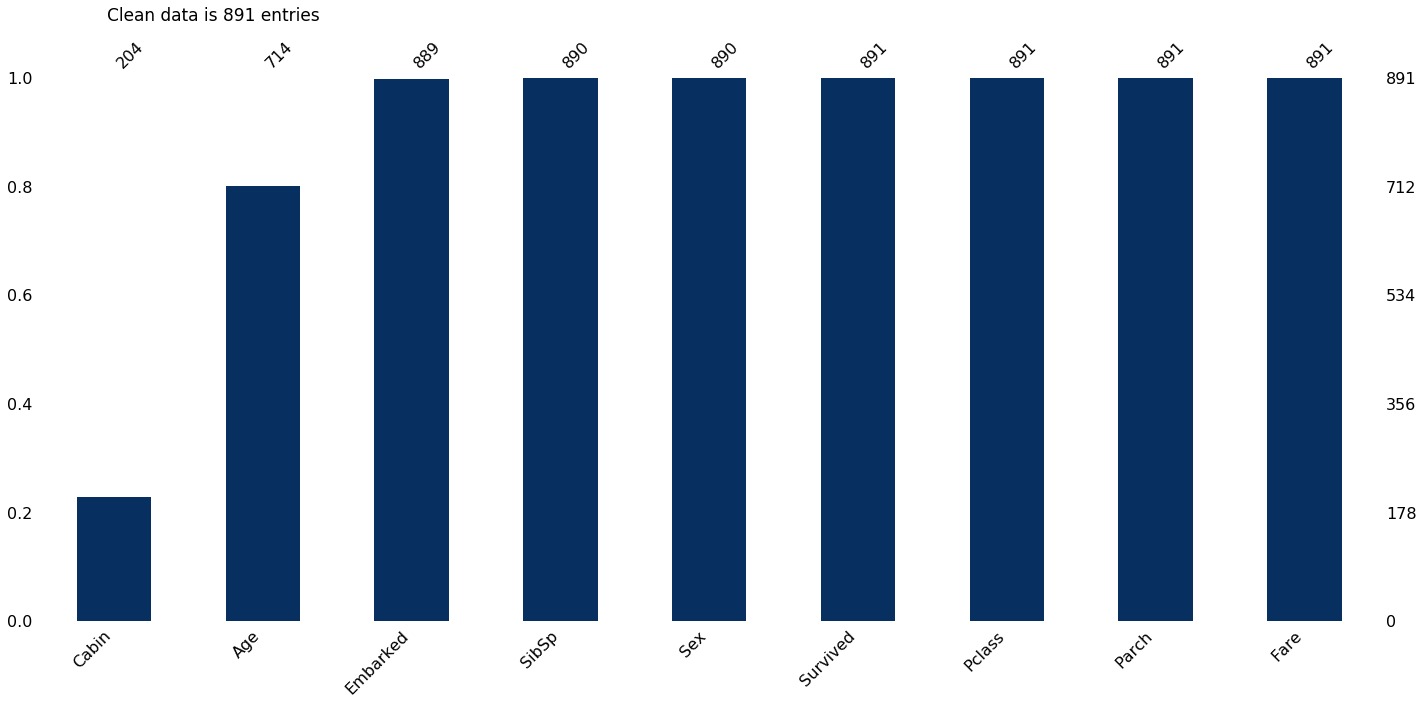




Generating graph for null matrix graph...


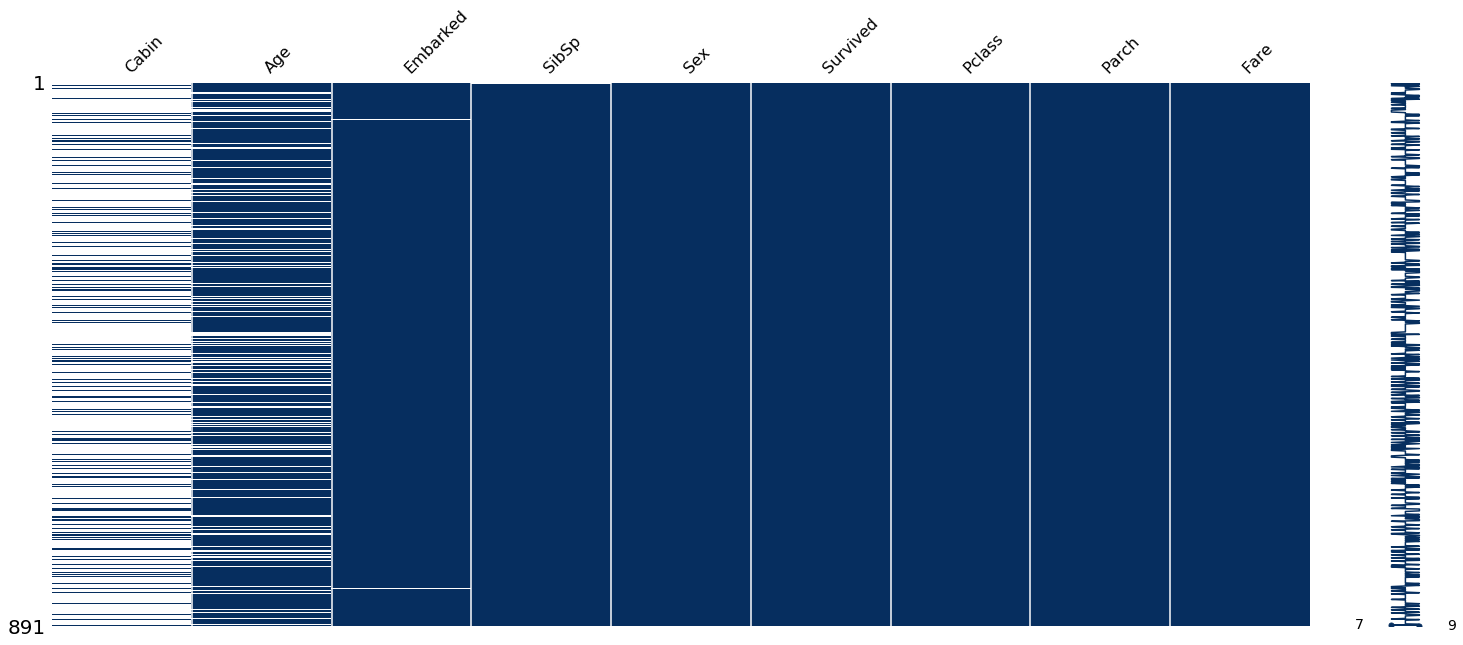




Generating graph for null heatmap...


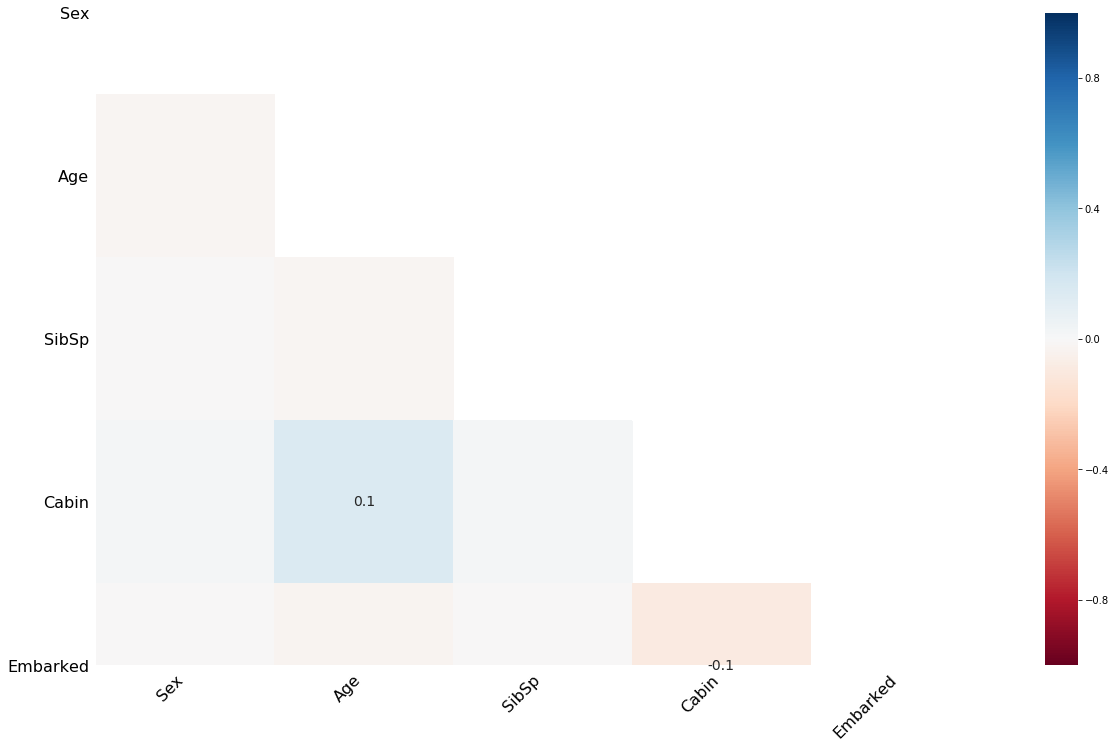




Generating graph for null dendrogram graph...


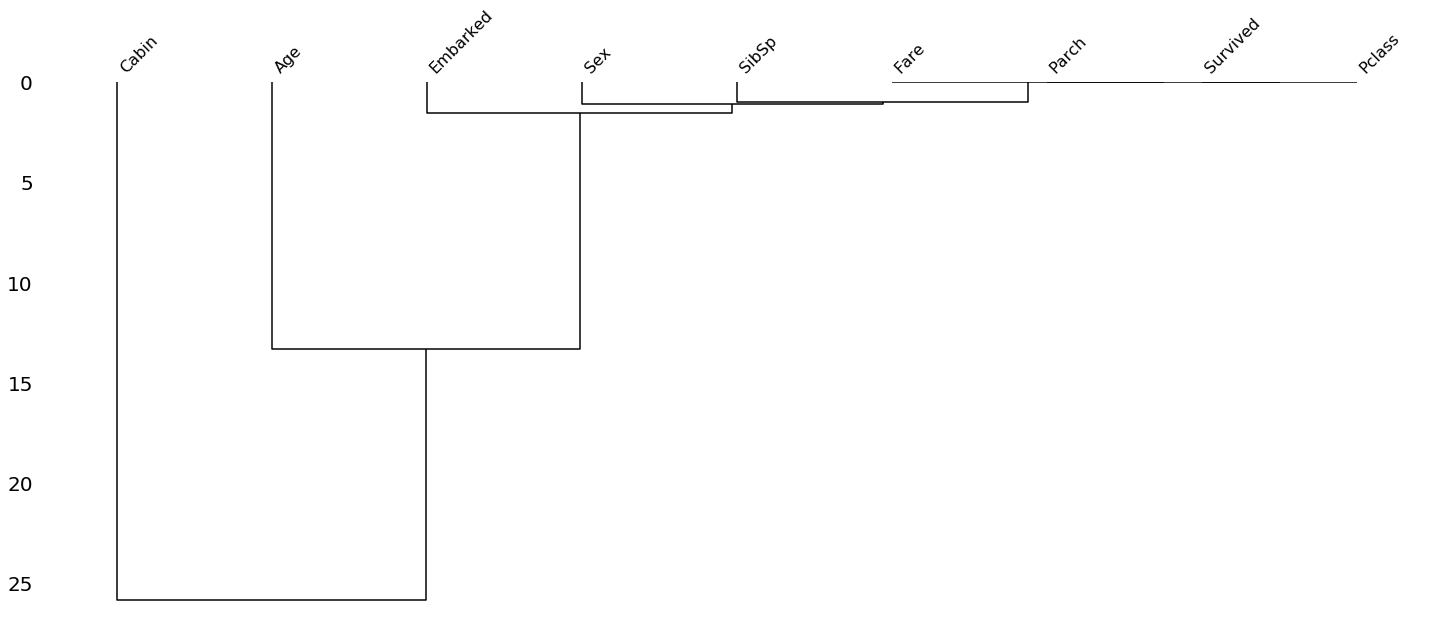

In [27]:
null_analysis = NullAnalysis(project_sub_dir=pre_processing_name,
                             notebook_mode=notebook_mode)

null_analysis.perform_analysis(df,
                               dataset_name=dataset_name)

del null_analysis

## Remove Unwanted Columns due to illogical nulls

### Interaction required

### Any features that have to many nulls/we can't or shouldn't perform any special logic to determine the closest or actual value

In [28]:
# create_new_cell_with_null_removal_features(df,null_threshold=0.25,replace=True)
remove_null_features = ["Cabin"]

### Add to main pipeline

In [29]:
if len(remove_null_features):
    data_transformer = DataTransformer()
    data_transformer.remove_features(df,
                                     df_features,
                                     remove_null_features)
    main_pipe.add("Remove unresolvable null features",
                  data_transformer)

    del data_transformer

# String Cleaning

# Data Type Changes

## Attempt to change/assert feature types for sanity purposes (The project makes assumptions based on df_features not the )

### Look at data types

In [30]:
data_types_table(df)

,Data Types
Features,
SibSp,float64
Fare,float64
Parch,int64
Survived,object
Pclass,object
Sex,object
Age,object
Embarked,object


### Make given data type changes

In [31]:
raise ValueError("fffff")

ValueError: fffff

In [ ]:
s = pd.Series(['1.asdgf0', '2', 1])
pd.to_numeric(s,errors='coerce')

### Looking at our type data before any null or value cleaning

In [ ]:
df_features.display_features(display_dataframes=False,
                             notebook_mode=True)

In [ ]:
data_types_table(df)

In [ ]:
import seaborn as sns
# i = 0
# colors = ["b", "g", "y", "black"]
# plt.close()
# sns.set(style="whitegrid")
# plt.figure(figsize=(12, 8))
# for target_val in df[target_feature].dropna().value_counts().index:
#     sns.distplot(df["Age"].dropna()[df[target_feature].dropna() == target_val], color=colors[i])
#     i += 1
# plt.show()

# plt.close()

# plt.figure(figsize=(12, 8))
# sns.barplot(
#             df[target_feature],
#             df["Pclass"],
#             label="Total",
#             color="b")
# plt.close()

# plt.figure(figsize=(12, 8))
# sns.jointplot(df["Fare"],df["Age"], color=colors[i])
# plt.show()
# plt.close()

# plt.figure(figsize=(12, 8))
# # Show each distribution with both violins and points
# sns.violinplot(df[target_feature], df["Age"], inner="points")
# plt.show()
# plt.close()


sns.pairplot(df[[feature_name for feature_name in df.columns if feature_name not in df_features.get_string_features()]], hue=f"{target_feature}", diag_kind='hist')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

tmp_df = pd.DataFrame(dict(target_feature=df[target_feature],
                           x=df["Age"]))

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.921, light=.7)
g = sns.FacetGrid(tmp_df,
                  row="target_feature",
                  hue="target_feature",
                  aspect=15,
                  height=.4,
                  palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot,
      "x",
      clip_on=False,
      shade=True,
      alpha=1,
      lw=1.5,
      bw=.2)
g.map(sns.kdeplot,
      "x",
      clip_on=False,
      color="w",
      lw=2,
      bw=.2)

g.map(plt.axhline,
      y=0,
      lw=2,
      clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2,
            label,
            fontweight="bold",
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.set_size_inches(10, 10, forward=True)
plt.title("Please work...")

In [ ]:
from pywaffle import Waffle
fig = plt.figure(
    FigureClass=Waffle, 
    rows=25, 
    columns=25, 
    values=df[target_feature].value_counts().to_dict(),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)},
    figsize=(7, 7)  # figsize is a parameter of matplotlib.pyplot.figure
)
plt.show()

# Analysis of feature data

In [ ]:
feature_analysis = FeatureAnalysis(project_sub_dir=pre_processing_name)
feature_analysis.perform_analysis(df,
                                  df_features,
                                  dataset_name=dataset_name)
del feature_analysis

### Begin testing

### Final look at data types

## Data Cleaning

In [ ]:
# from impyute.imputation.cs import mice

# a = df["Age"].tolist()
# # start the MICE training
# imputed_training=mice(df.values)

In [ ]:
# import datawig

# df_train, df_test = datawig.utils.random_split(df)

# #Initialize a SimpleImputer model
# imputer = datawig.SimpleImputer(
#     input_columns=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin','Embarked'], # column(s) containing information about the column we want to impute
#     output_column= 'Age', # the column we'd like to impute values for
#     output_path = 'imputer_model' # stores model data and metrics
#     )

# #Fit an imputer model on the train data
# imputer.fit(train_df=df, num_epochs=200)

In [ ]:
# imputed_training=mice(df[df_features.get_numerical_features()].values)

In [ ]:
import random

test = df.drop(columns=["Date_test", "Embarked"]).dropna()

test["Sex"] = df["Sex"] == "male"
test[target_column] = [random.randint(0, 2) for _ in range(0,test.shape[0])]
print(len(test[target_column]))

y = test[target_column].values
X = test.values

print(X.shape)
print(y.shape)


df_features = DataFrameTypes(test,
                             target_column=target_column,
                             ignore_nulls=True) 
df_features.get_all_features()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=517, stratify=y,
)

In [ ]:
display(set(y_train))
set(y_test)

In [ ]:
# Find best parameters for model
param_grid = {
    "max_depth": list(range(2, 3)),
    "min_samples_leaf": list(range(80, 130, 5)),
    "criterion": ["gini", "entropy"],
#     "n_splits": [20, 30]
}

model, best_params = optimize_model_grid(
    model=DecisionTreeClassifier(),
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    scoring="f1_macro"
)

In [ ]:
dt_analysis = ClassificationAnalysis(model=model,
                                     pred_funcs_dict={"Probabilities function":model.predict_proba,
                                                      "Predict function":model.predict},
                                     sample_data=X_train,
                                     model_name=repr(model).split("(")[0],
                                     project_name=f'{parent_project_name}/Classification Analysis',
                                     notebook_mode=True,
                                     df_features=df_features)

dt_analysis.perform_analysis(X=X_train,
                             y=y_train,
                             dataset_name="Training Data",
                             thresholds_matrix=[[.2,.2,.2,.2,.2,.2,.2,.2,.2,.2,.2],
                                               ])

In [ ]:
X_train

In [ ]:
os.path.exists("/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eFlow Data/Pre processing/Supervised Analysis/DecisionTreeClassifier/Probabilities function/Thresholds")

In [ ]:
get_unique_directory_path(os.getcwd() + "/eFlow Data/Pre processing/Supervised Analysis/DecisionTreeClassifier/Test data/Probability Classification/",
                        "Model Results")

In [ ]:
error_string = os.getcwd().replace("/", "///")
error_string

In [ ]:
ab = "/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eFlow Data/Pre processing/Supervised Analysis/DecisionTreeClassifier/Test data/Probability Classification"
correct_directory_path(ab)

In [ ]:
a=[[1,2],[1,2,3],[1]]
c = copy.deepcopy(a)
b=np.array(a)
b.tolist()
hhh = None
if hhh:
    print("test")

In [ ]:
bbb = None

if not bbb:
    print("test")
else:
    print("fff")

In [ ]:
vector_y = copy.deepcopy(y_test)
vector_y = np.where(vector_y==0, "Test", vector_y) 
vector_y = np.where(vector_y=='1', "Blarg", vector_y)
vector_y = np.where(vector_y=='2', "Dragon", vector_y)
vector_y

In [ ]:
skplt.metrics.plot_confusion_matrix(vector_y, vector_y)

In [ ]:
thresholds = [0, 0, 8.3, 0, 0, 0, 0, 0, 0, 0, .36]

model_output = model.predict_proba(X_train)

print(model_output)
# Validate probabilities
if thresholds:
    if isinstance(thresholds, list) or \
            isinstance(thresholds, np.ndarray):
        if sum(thresholds) < .98:
            print("Thresholds didn't add up to 98%-100%! "
                  "This may cause issues in your results!")
    else:
        raise ThresholdType

# ---
if isinstance(model_output, list):
    model_output = np.asarray(model_output)

if isinstance(model_output, np.ndarray):
    if thresholds:
        outputs_passed_threshold = model_output > np.asarray(thresholds)
outputs_passed_threshold

In [ ]:
!pip install warning

In [ ]:
import warnings
class UnExpectedData(UserWarning, ValueError):
    pass

In [ ]:
model_output

In [ ]:
model_output = model.predict_proba(X_train)
bool_matrix_thresholds = model_output < np.asarray([.2,.2,.2,.2,.2,.2,.2,.2,.2,.2,.2])

tmp_matrix = []
for bool_vector in bool_matrix_thresholds:
    tmp_vector = []
    for i,passed in enumerate(bool_vector):
        if passed:
            tmp_vector.append(model_output[i][0])
        else:
            tmp_vector.append(float("-inf"))
    tmp_matrix.append(tmp_vector)
print(tmp_matrix[1])

In [ ]:
import missingno as msno

In [ ]:
display(df.isnull().sum())



In [ ]:
ax = msno.bar(df[df.columns[df.isna().any()].tolist()],
              color="#072F5F")

In [ ]:
features = df.isnull().sum().index.tolist()
null_values = df.isnull().sum().values.tolist()
null_sorted_features, null_values = zip(*sorted(zip(null_values,
                                                    features)))

for feature_index, value in enumerate(null_values):
    if value == 0:
        break

In [ ]:
from eflow._hidden.utils.meta_data_identity import check_create_metadata_of_dataframe
testing_path = "/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eflow Data/Pre processing/Missing Data/All Data"
check_create_metadata_of_dataframe(df,
                                   testing_path)

In [ ]:

import math
feature_name = "Feature_name"
for hash_type in [1,2,3,4,5,6,7,8,9,10]:
    result = 0
    for char_index, char in enumerate(feature_name):
        if hash_type == 1:
            result += int(ord(char))
        elif hash_type == 2:
            result += int(ord(char) + 62 * ord(char))
        elif hash_type == 3:
            result += int(ord(char) + 147 * ord(char))
        elif hash_type == 4:
            result += int((ord(char) + 92) * math.pow(ord(char), 3))
        elif hash_type == 5:
            result += int(ord(char) + 49 * math.pow(ord(char), 2))
        elif hash_type == 6:
            result += int((23 + ord(char) + 45) * (3 + ord(char) + 2))
        elif hash_type == 7:
            result += int((ord(char) * 5) + 32 + 8)
        elif hash_type == 8:
            result += int(math.pow(ord(char), 2))
        elif hash_type == 9:
            result += int(ord(char) * 2 + 32 + ord(char) * 2 + 5)
        elif hash_type == 10:
            result += int(ord(char) * 12 + 76 + math.pow(ord(char), 2))

In [ ]:
import numpy as np



In [ ]:
df["Ticket"][891]

In [ ]:
np.array([1,2,3]) % 3

In [ ]:
testing=[1,2,3]
for shit in df.columns:
    print(shit)